# Comparision between different types of matrix


In [47]:
# environment settings

# Visualization
import matplotlib.pyplot as plt
# System to get memory allocation
import sys
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

## The method for evaluating the size of an object

In [18]:
'''
Borrow from https://stackoverflow.com/a/30316760/11007369
To get the memory size of an object.(Deep search)
'''

from types import ModuleType, FunctionType
from gc import get_referents

# Custom objects know their class.
# Function objects seem to know way too much, including modules.
# Exclude modules as well.
BLACKLIST = type, ModuleType, FunctionType


def getsize(obj):
    """sum size of object & members."""
    if isinstance(obj, BLACKLIST):
        raise TypeError('getsize() does not take argument of type: '+ str(type(obj)))
    seen_ids = set()
    size = 0
    objects = [obj]
    while objects:
        need_referents = []
        for obj in objects:
            if not isinstance(obj, BLACKLIST) and id(obj) not in seen_ids:
                seen_ids.add(id(obj))
                size += sys.getsizeof(obj)
                need_referents.append(obj)
        objects = get_referents(*need_referents)
    return size/1024

## Different matrices

### List of lists (LIL)

<img src='img/Triples_to_LIL.png' width=800>

* The List is consist of inner lists which are sorted by rows ascendingly. 
* Each inner list connects the non-zero items with sorted columns 

In [23]:
# classes for the triple matrix

'''
Triple is a very basic element in the triple matrix, which is consisted of a list that connects 
all non_zero rows. A non_zero row contains non_zeros' column indexes and values. The back-stage mechanism is the binary search.
'''

class Triple:
    def __init__(self, row):
        # safety check 
        if(row < 0):
            raise Exception('row should be positive.')
        self.row = row
        self.colList = []
        self.valList = []
    def __repr__(self):
        return 'row: {}\nColumn List:\t{}\nValue List:\t{}'.format(
            self.row,
            ',\t'.join(str(c) for c in self.colList),
            ',\t'.join(str(v) for v in self.valList))
        
    def __str__(self):
        ret = ['{}\t{}\t{}\n'.format(
            self.row,
            self.colList[i],
            self.valList[i] 
        ) for i in range(0, len(self.colList))]
        return '\n'.join(ret)
    
      
        
    def add(self, col, val):
        # saftey check 
        if(col < 0):
            raise Exception('col should be positive.')
        # check if there is a column index in the colList
        if(col in self.colList):
            idx = self.colList.index(col)
            self.colList[idx] = col
            self.valList[idx] = val
       # insert an item into the triple
        else:
            idx = bct.bisect_left(self.colList, col)
            self.colList.insert(idx, col)
            self.valList.insert(idx, val)      

In [54]:
# test 
t = Triple(3)
t.add(2, 3.)
t.add(3, 5.)
t.add(2, 2.)
t

row: 3
Column List:	2,	3
Value List:	2.0,	5.0

In [55]:
print(t)

3	2	2.0

3	3	5.0



In [24]:
import bisect as bct

'''
TripleMatrix maintains the row indexes in the ascending order since the beginning, also for each Triple in the list, 
columns' indexes are kept too. The back-stage mechanism is the binary search.
'''

class TripleMatrix:
    def __init__(self, row, col):
           # safety check 
        if(row < 0 or col < 0):
            raise Exception('row and column numbers are positive.')
        # matrix size
        self.row = row
        self.col = col
        # non_zero list
        self.nzList = []
        # record rows indexes
        self.rows = []
        
    def __repr__(self):
        return '\n'.join(n.__str__() for n in self.nzList)
    
    def __str__(self):
        return 'row: {}\ncol: {}\n\nRow\tColumn\tValue\n{}'.format(self.row, self.col, self.__repr__())
    
    def set(self, row, col, val):
        # check 
        if(row >= self.row or col >= self.col):
            raise Exception('out of matrix bound.')
        # found
        if(row in self.rows):
            idx = self.rows.index(row)
            self.nzList[idx].add(col, val)
        else:
            idx = bct.bisect_left(self.rows, row)
            self.rows.insert(idx, row)
            triple = Triple(row)
            triple.add(col, val)
            self.nzList.insert(idx, triple)

In [73]:
# test
t = TripleMatrix(2, 3)
t.set(1,1,2.2)
t.set(0,2,3.)
t.set(0,1,2.)
t.set(0,1,3.3)

In [74]:
t

0	1	3.3

0	2	3.0

1	1	2.2

In [75]:
print(t)

row: 2
col: 3

Row	Column	Value
0	1	3.3

0	2	3.0

1	1	2.2



### Compressed sparse column(CSC)

<img src='img/CSC.png' width = 600>

Why not break down the lists since there will be cost both in storage and time to maintain the data structure?
<br>
If we could find the relationship between indexes and the data, the problem will be solved out.
<br>
Each column could be compressed into a vector including all data in a column, like the example below.

<img src='img/CSC_2.png' width = 800> 

Use binary search to speed up

In [34]:
from math import floor


def binary_search(Array, Search_Term, L, R):
    # R should be reset
    R = R - 1 
    while L <= R:
        mid = floor((L + R) / 2)
        if Array[mid] < Search_Term:
            L = mid + 1
        elif Array[mid] > Search_Term:
            R = mid - 1
        else:
            return mid
    return -1


In [28]:
class CSC:
    def __init__(self, row, col):
        # safety check
        if row < 0 or col < 0:
            raise Exception('row and column numbers are positive.')
        self.row = row
        self.col = col
        # initialize data, reference values
        self.data = []
        #  Specifies which row a specific non-zero value corresponds to
        self.f_rows = []
        # Stores the range of indexes in the non-zero lists that belong to each column.
        self.f_cols = [0] * (col + 1)

    def __repr__(self):
        nz_list = []
        for r in range(0, self.row):
            for c in range(0, self.col):
                idx = self.get_idx(r, c)
                if(idx != -1):
                    nz_list.append('{}\t'.format(self.data[idx]))
                else:
                    nz_list.append('{}\t'.format(0.))
            nz_list.append('\n')
        return ''.join(nz_list)

    def __str__(self):
        return 'row: {}\ncol: {}\n\n{}'.format(self.row, self.col, self.__repr__())

    # boundary condition => empty
    def set(self, row, col, val):
        # safety check
        if row >= self.row or col >= self.col:
            raise Exception('out of matrix bound.')

        idx = self.get_idx(row, col)
        #  not exist
        if idx == -1:
            idx_0 = self.f_cols[col]
            idx_1 = self.f_cols[col + 1]
            idx = idx_0

            # determine the index the new element should be inserted at
            for idx in range(idx_0, idx_1):
                if row < self.f_rows[idx]:
                    break

            # shift
            for i in range(col + 1, len(self.f_cols)):
                self.f_cols[i] = self.f_cols[i] + 1
                
            self.f_rows.insert(idx, row)
            self.data.insert(idx,val)

        else:
            self.data[idx] = val

    # return data index
    def get_idx(self, row, col):
        # safety check
        if row < 0 or col < 0:
            raise Exception('row and column numbers are positive.')
        if row >= self.row or col >= self.col:
            raise Exception('out of matrix bound.')

        # get the column range
        idx_0 = self.f_cols[col]
        idx_1 = self.f_cols[col + 1]

        # check row in the same index using binary search
        nz_idx = binary_search(self.f_rows, row, idx_0, idx_1)

        # not found
        return nz_idx





In [35]:
csc = CSC(3, 2)
csc.set(2, 1, 0.2)
csc.set(2, 0, 8.)
csc.set(1, 1, 2.2)
csc.set(2, 0, 1.2)

print(csc)

row: 3
col: 2

0.0	0.0	
0.0	2.2	
1.2	0.2	



In [12]:
csc.data

[1.2, 8.0, 2.2, 0.2]

### Dense matrix(DM)

In [20]:
class DM:
    def __init__(self, row, col):
        # safety check 
        if(row < 0 or col < 0):
            raise Exception('row and column numbers are positive.')
        self.row = row
        self.col = col
        # fix length
        self.data = [0.]*(row*col)
    
    def __repr__(self):
        return '\n'.join('\t'.join(str(self.get(i, j)) for j in range(0, self.col)) for i in range(0, self.row))
    
    def __str__(self):
        return 'row: {}\ncol: {}\n\n{}'.format(self.row, self.col, self.__repr__())
    
    def set(self, row, col, val):
        # safety check 
        if(row >= self.row or col >= self.col):
            raise Exception('out of matrix bound.')
        self.data[self.index(row,col)] = val
    
    def get(self, row, col):
         # safety check 
        if(row >= self.row or col >= self.col or row < 0 or col < 0):
            raise Exception('out of matrix bound.')
        return self.data[self.index(row,col)]
                         
    def index(self, row, col):
        return row*self.col + col
    

In [88]:
# test
dm = DM(2,3)
dm.set(1, 2, 2.2)
dm.set(0, 1, 1. )
dm

0.0 1.0 0.0
0.0 0.0 2.2

In [89]:
print(dm)

row: 2
col: 3

0.0 1.0 0.0
0.0 0.0 2.2


## Storage test

D:\environment\Anaconda\lib\site-packages\ipykernel_launcher.py:57: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


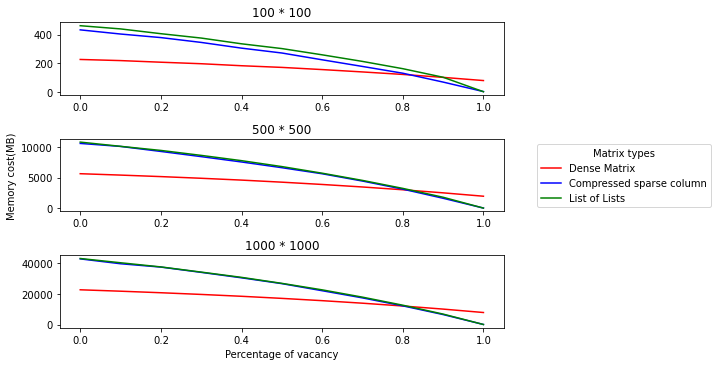

In [51]:
import numpy as np
from random import *
# square matrixes sizes
test_size = [100, 500, 1000]
# empty rate
et_list = np.linspace(0, 1, 11).tolist() 
# figures
idx = 0
fig, axs = plt.subplots(3, 1, figsize=(7, 5))
lines = []
fig.subplots_adjust(top=0.8)

# set random matrix
for ts in test_size:
    # memory size
    ms_dm = []
    ms_csc = []
    ms_tm = []
    for et in et_list:
        # non-zeros number
        nz = (int)(ts*ts*(1-et))
        
        # Matrices
        dm = DM(ts, ts)
        csc = CSC(ts, ts)
        tm = TripleMatrix(ts, ts)
    
        # random locations
        xy = np.random.randint(0,ts,size=(nz, 2))
        # set matrix
        for i in range(0, nz):
            x = xy[i, 0]
            y = xy[i, 1]
            val = random()
            dm.set(x, y, val)
            csc.set(x, y, val)
            tm.set(x, y, val)
        # record memory cost
        ms_dm.append(getsize(dm))
        ms_csc.append(getsize(csc))
        ms_tm.append(getsize(tm))
    
    # visualize
    axs[idx].plot(et_list, ms_dm, label='Dense Matrix', color='red')
    axs[idx].plot(et_list, ms_csc, label='Compressed sparse column', color='blue')
    axs[idx].plot(et_list, ms_tm, label= 'List of Lists', color='green')
    axs[idx].set_title('{} * {}'.format(ts, ts))
    idx = idx + 1
    if(idx == len(test_size)):
        handles, labels = axs[idx-1].get_legend_handles_labels()
        
# Create the legend
fig.legend(handles,     # The line objects
           labels = labels,   # The labels for each line
           loc="center right",   # Position of legend
           bbox_to_anchor=(1.4, 0.5),
           title="Matrix types"  # Title for the legend
           )

fig.tight_layout()
axs[2].set_xlabel('Percentage of vacancy')
axs[1].set_ylabel('Memory cost(MB)')


fig.savefig('img\storage.png'.format(ts), dpi=300, bbox_inches='tight')